In [1]:
%load_ext autoreload
%autoreload 2

Import modules

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset

from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis_OLD, _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks_OLD, matrix_to_blocks

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

In [4]:
orbitals = {
    'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]}
}

In [5]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 4
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True] 

kmesh = [8,8,1]
kfock = [np.load(f"{root}/c2/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/c2/over_{i}_881.npy") for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2, 
                               fix_p_orbital_order = True,
                               apply_condon_shortley = False,
                               fock_kspace = kfock, 
                               overlap_kspace = kover,
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = ORBS)

In [6]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 4
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True] 

kmesh = [8,8,1]

dataset_fake = PySCFPeriodicDataset(frames = frames, 
                                    kmesh = kmesh, 
                                    dimension = 2, 
                                    fix_p_orbital_order = False,
                                    apply_condon_shortley = False,
                                    fock_kspace = rHk,
                                    overlap_kspace = kover,
                                    device = device, 
                                    orbs = orbitals[ORBS], 
                                    orbs_name = ORBS)

NameError: name 'rHk' is not defined

# Targets

In [15]:
from metatensor import sort
cutoff = 8.35
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

In [132]:
from mlelec.utils.pbc_utils import blocks_to_matrix
rHT = blocks_to_matrix(target_blocks, dataset)
rHk = dataset.bloch_sum(rHT)
print(torch.norm(rHk[0]-dataset.fock_kspace[0]))

tensor(0.0366)


In [16]:
from mlelec.utils.pbc_utils import kmatrix_to_blocks
k_target_blocks = kmatrix_to_blocks(dataset, all_pairs = False, cutoff = cutoff)

In [134]:
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums, TMap_bloch_sums_OLD
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
tb = _to_uncoupled_basis(target_coupled_blocks)
phase, where_inv = precompute_phase(tb, dataset_fake, cutoff=np.inf)
_k_target_blocks = TMap_bloch_sums(tb, phase, where_inv)

In [135]:
from mlelec.utils.pbc_utils import kmatrix_to_blocks
k_target_blocks = kmatrix_to_blocks(dataset_fake, all_pairs = False, cutoff = np.inf)

In [136]:
from mlelec.utils.pbc_utils import kblocks_to_matrix
m = kblocks_to_matrix(k_target_blocks,dataset_fake)
m2 = kblocks_to_matrix(_k_target_blocks,dataset_fake)

# Features

In [8]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
max_radial  = 6
max_angular = 6
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = True
all_pairs = False
LCUT = 3

def compute_features(dataset):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = None, 
                          T_dict = None)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [9]:
hfeat = compute_features(dataset)

/home/pegolo/Software/mlelec/src/mlelec/features/acdc.py:319: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


# Train

## Ridge regression

In [13]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [113]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [114]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, 2, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(1.9861e-05)


Compute the feature covariance matrix and diagonalize it. Project the weights onto the covariance eigenstates at each training iteration (TODO)

## Torch

In [10]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [11]:
from mlelec.models.linear import LinearModelPeriodic

In [12]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [17]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False,
                            nhidden = 32, 
                            nlayers = 1,
                            train_kspace = False,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
last_layer_kernel = {}
nepoch = 500

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 5e-4, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

In [18]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

phase, where_inv = precompute_phase(target_blocks, dataset, cutoff=np.inf)

loss_real = []
loss_k = []

new_sched = True
for epoch in range(nepoch):

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 0:
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
        epoch_loss = epoch_loss.item()
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), .5)
            optimizers[ik].step()
            # schedulers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
            
        unc_pred = _to_uncoupled_basis(pred, cg = CG)
        pred_kspace = TMap_bloch_sums(unc_pred, phase, where_inv)
        loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 128).item())
        loss_real.append(epoch_loss)
        # for ik, (key, loss) in enumerate(model.model):
        
    else:
        # if new_sched:
        #     pred_before_k = pred.copy()

        #     optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 200, verbose=True)
        #     # for s, o in zip(schedulers, optimizers):
        #     #     s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.5, patience = 100, verbose=True)
        #     new_sched = False

        #     _loss = L2_kspace_loss(pred, 
        #                       target_kspace, 
        #                       dataset, 
        #                       cg = CG, 
        #                       kpts = kpts_,
        #                       norm = 1
        #                       )
        #     print("Initial k-space loss = ", _loss.item())

        unc_pred = _to_uncoupled_basis(pred, cg = CG)
        pred_kspace = TMap_bloch_sums(unc_pred, phase, where_inv)
        loss = L2_loss(pred_kspace, k_target_blocks, norm = 128)
        loss_real.append(L2_loss(pred, target_coupled_blocks).item())
        # pred_kspace = None # Allow to deallocate
        # loss = L2_kspace_loss(pred, 
        #               target_kspace, 
        #               dataset, 
        #               cg = CG, 
        #               kpts = kpts_,
        #               norm = 1
        #               ) 

        loss.backward(retain_graph = False)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        epoch_loss = loss.item()

        loss_k.append(epoch_loss)
        # for key in model.model:
        #     if key not in losses:
        #         losses[key] = [epoch_loss/len(model.model)]
        #     else:
        #         losses[key].append(epoch_loss/len(model.model))
    
        for ik, key in enumerate(model.model):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss)
        
        # optimizer.step()
        # scheduler.step(epoch_loss)

    # for i, key in enumerate(model.model):
    #     if key not in para:
    #         para[key] = {}
    #         # grad[key] = []
    #         # optimizers[0].param_groups[0]['lr']
    #     for i, param in enumerate(model.model[key].parameters()):
    #         # grad[key].append(param.grad.norm().item())
    #         if i not in para[key]:
    #             para[key][i] = []
    #         para[key][i].append(torch.clone(param).detach())

    # for k in model.target_blocks.keys:
    #     kl = tuple(k.values)
    #     if kl not in last_layer_kernel:
    #         last_layer_kernel[kl] = []
    #     feat = map_targetkeys_to_featkeys(hfeat, k)
    #     m = model.model[str(kl)].mlp[:-1].forward(feat.values).detach()
    #     # if epoch == 0:
    #     #     print(kl, m.shape)
    #     # m = m.reshape(-1, m.shape[-1])
    #     mTm = torch.einsum('scf,Scf->csS', m, m)
    #     # mTm = torch.einsum('scf,scg->cfg', m, m)
    #     last_layer_kernel[kl].append(mTm)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

        # for i, key in enumerate(model.model):
        #     if key not in para:
        #         para[key] = []
        #         grad[key] = []
        #         # optimizers[0].param_groups[0]['lr']
        #     for param in model.model[key].parameters():
        #         grad[key].append(param.grad.norm().item())
        #         para[key].append(param.norm().item())

    #     # validate 
    #     valpred = model.predict(hfeat_test, target_test)
    #     if loss_func == 'kspace':
    #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
    #     else:
    #         val_loss = L2_loss(valpred, target_test)
        
    #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks 1192.2475792528, train loss per prediction 1.18860e-03
Epoch      10, train loss on all blocks  745.2073113555, train loss per prediction 9.39707e-04
Epoch      20, train loss on all blocks  422.1212701673, train loss per prediction 7.07249e-04
Epoch      30, train loss on all blocks  191.1696546335, train loss per prediction 4.75952e-04
Epoch      40, train loss on all blocks   35.3088386861, train loss per prediction 2.04548e-04
Epoch      50, train loss on all blocks    4.5722482942, train loss per prediction 7.36069e-05
Epoch      60, train loss on all blocks    1.7332428386, train loss per prediction 4.53193e-05
Epoch      70, train loss on all blocks    1.2106128926, train loss per prediction 3.78753e-05
Epoch      80, train loss on all blocks    0.7158313927, train loss per prediction 2.91246e-05
Epoch      90, train loss on all blocks    0.1802300046, train loss per prediction 1.46139e-05
Epoch     100, train loss on all blocks    0.60740


KeyboardInterrupt



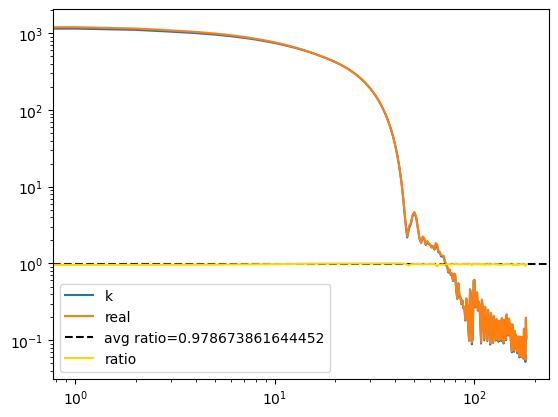

In [19]:
plt.loglog(loss_k, label='k')
plt.loglog(loss_real, label='real')
plt.axhline(np.mean(np.array(loss_k)/np.array(loss_real)), label = f'avg ratio={np.mean(np.array(loss_k)/np.array(loss_real))}', ls = '--', color = 'k')
plt.loglog(np.array(loss_k)/np.array(loss_real), label='ratio', color = 'gold')

plt.legend()

# Bands

In [828]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [829]:
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 8.35, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 8.35)

-0.05818612802315126
-0.05778862241215634


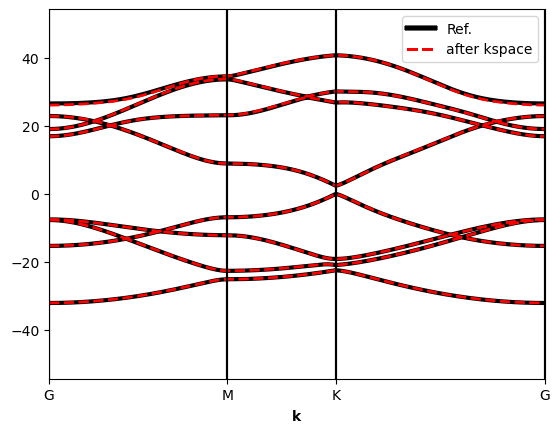

In [834]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 2
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[ifr].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[ifr].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[ifr]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_k], [rS_k], ['red'], ['--'], [1], ['after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
        # continue
    realfock_cutoff = np.asarray(list(H[ifr].values()))
    realover_cutoff = np.asarray(list(S[ifr].values()))
    R_vec_rel = [list(T) for T in H[ifr]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



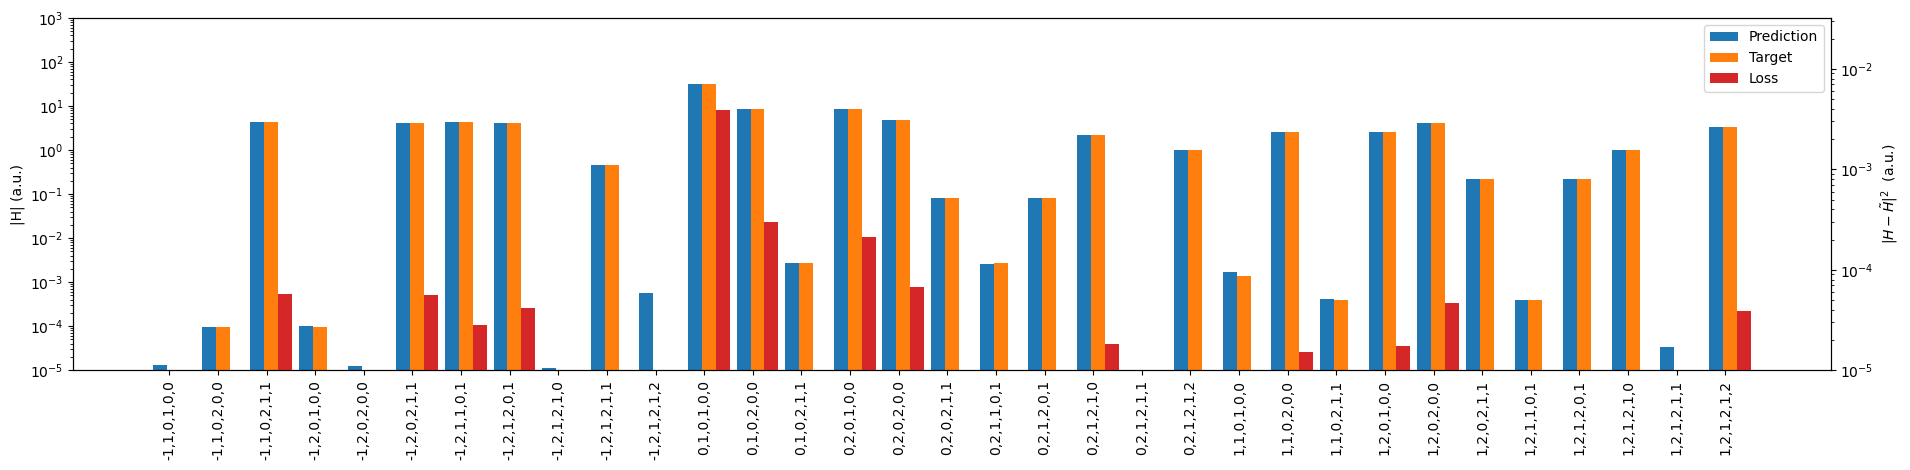

In [835]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

# Understanding the factor to equate real and kspace TMap losses

In [672]:
# ni = 2
# li = 1
# nj = 2
# lj = 1

for ni,li,nj,lj in [[1,0,1,0], [1,0,2,0], [1,0,2,1], [2,0,2,0], [2,0,2,1], [2,1,2,1]]:
    
    pred = model()
    pred_unc = _to_uncoupled_basis(pred)
    
    simple_pred = []
    simple_k = []
    for k, b in pred_unc.items():
        if k['n_i'] == ni and k['l_i'] == li and k['n_j'] == nj and k['l_j'] == lj: # and k['block_type'] != 0:
            simple_pred.append(b.copy())
            simple_k.append(k.values.tolist())
    simple_k = Labels(pred_unc.keys.names, np.array(simple_k))
    simple_pred = TensorMap(simple_k, simple_pred)
    
    simple_targ = []
    simple_k = []
    for k, b in target_blocks.items():
        if k['n_i'] == ni and k['l_i'] == li and k['n_j'] == nj and k['l_j'] == lj:
            simple_targ.append(b.copy())
            simple_k.append(k.values.tolist())
    simple_k = Labels(target_blocks.keys.names, np.array(simple_k))
    simple_targ = TensorMap(simple_k, simple_targ)
    
    simple_pred = metatensor.zeros_like(simple_pred)
    simple_targ = metatensor.ones_like(simple_targ)
    
    phase, where_inv = precompute_phase(simple_targ, dataset)
    simple_targ_k = TMap_bloch_sums(simple_targ, phase, where_inv)
    simple_pred_k = TMap_bloch_sums(simple_pred, phase, where_inv)
    
    loss = {}
    loss['k'] = L2_loss(simple_pred_k, simple_targ_k, loss_per_block=False).item()
    loss['r'] = L2_loss(simple_pred, simple_targ, loss_per_block=False).item()
    
    vals = {}
    for tmap, l in zip([simple_pred, simple_pred_k], ['r', 'k']):
        tot = 0
        # print(l)
        for i, (k, b) in enumerate(tmap.items()):
            # print(k.values)
            # print(b.values.shape, np.prod(b.values.shape))
            # tot += b.values.shape[2]*b.values.shape[1]
            tot += np.prod(b.values.shape)
            # print(np.prod(b.values.shape))
            # print()
        # print()
        vals[l] = tot #/(i+1)
    
    # for l in vals:
    #     print(l, loss[l], vals[l])
    
    # print('vals',vals['k']/vals['r'])
    print(f'{ni}{li}-{nj}{lj}   nk={vals["k"]}, nr={vals["r"]}, nk/nr={vals["k"]/vals["r"]}') # Average number of predictions per block {vals["k"]:.3f}, {vals["r"]:.3f} {vals["k"]/vals["r"]}')
    print('loss_k ={:>10.4f}     loss_r ={:>8.4f}     loss_k/loss_r ={:>8.4f}     (loss_k/loss_r)/(nk/nt) ={:>20.15f}'.format(loss['k'], loss['r'], loss['k'] / loss['r'], (loss['k'] / loss['r'])/(vals["k"]/vals["r"])))
    # print('loss {:>10.4f} {:>8.4f} {:>8.4f}'.format(loss['k']/vals['k'], loss['r']/vals['r'], (loss['k']/vals['k'])/(loss['r']/vals['r'])))
    # print('loss {:>10.4f} {:>8.4f} {:>8.4f}'.format(loss['k']/vals['k']**2, loss['r']/vals['r']**2, (loss['k']/vals['k']**2)/(loss['r']/vals['r']**2)))
    # print('loss', loss['k']/vals['k'] / loss['r']*vals['r'])
    
    # for l in vals:
        # print(l, loss[l]/vals[l])
    
    # rat = (loss['k']/loss['r']) / (vals['k']/vals['r'])
    # print(rat)
    
    # print((64/rat)**2)

10-10   nk=128, nr=8, nk/nr=16.0
loss_k =  384.0000     loss_r =  8.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   3.000000000000000
10-20   nk=128, nr=8, nk/nr=16.0
loss_k =  384.0000     loss_r =  8.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   3.000000000000000
10-21   nk=384, nr=24, nk/nr=16.0
loss_k = 1152.0000     loss_r = 24.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   2.999999999999998
20-20   nk=128, nr=8, nk/nr=16.0
loss_k =  384.0000     loss_r =  8.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   3.000000000000000
20-21   nk=384, nr=24, nk/nr=16.0
loss_k = 1152.0000     loss_r = 24.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   2.999999999999998
21-21   nk=1152, nr=72, nk/nr=16.0
loss_k = 3456.0000     loss_r = 72.0000     loss_k/loss_r = 48.0000     (loss_k/loss_r)/(nk/nt) =   3.000000000000000


/tmp/ipykernel_663744/222490466.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=3, figsize = (fs[0]*2, fs[1]/1.5))


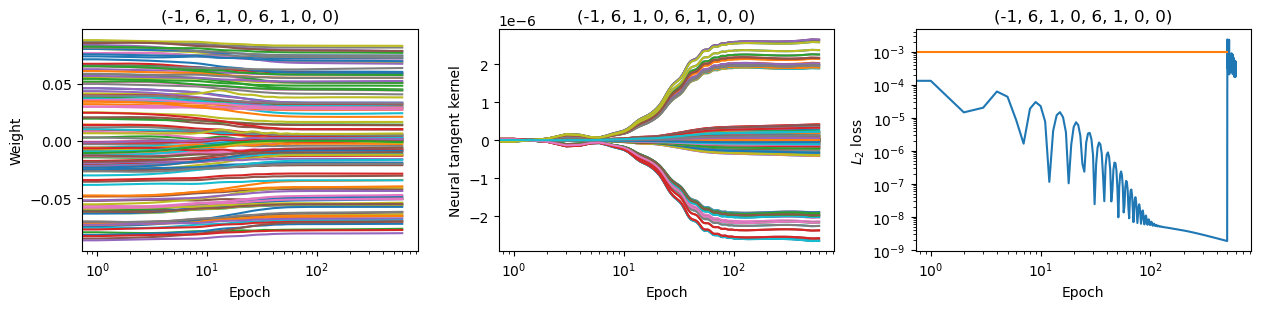

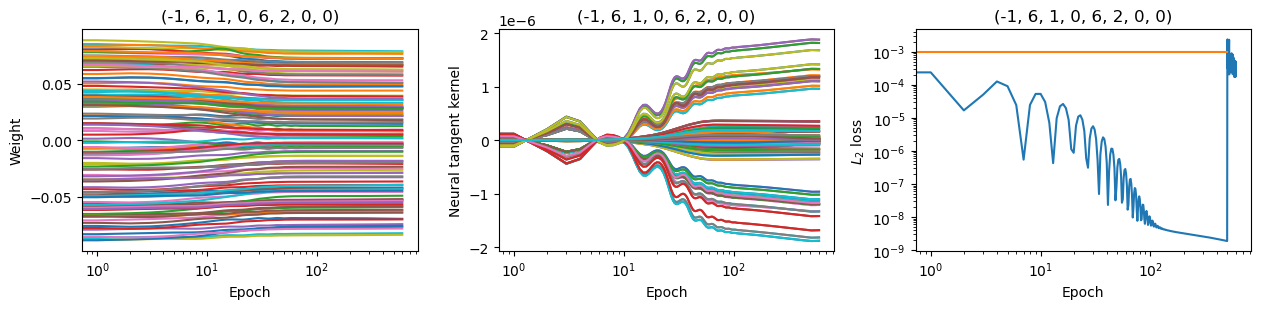

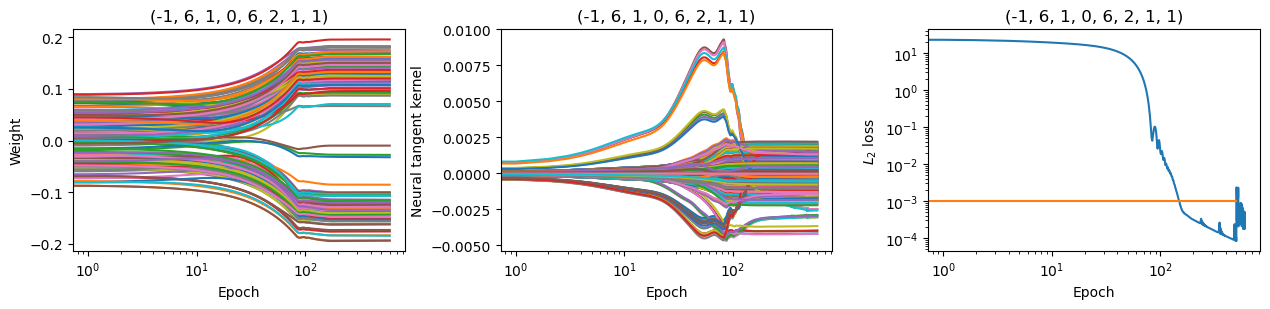

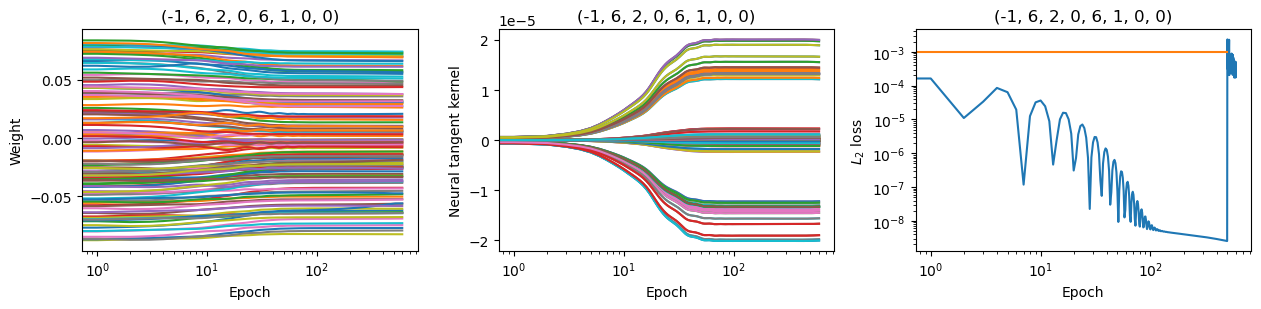

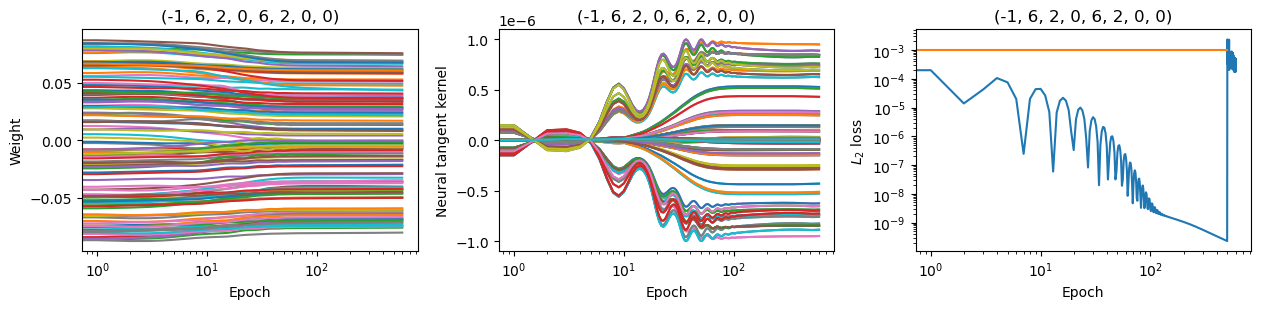

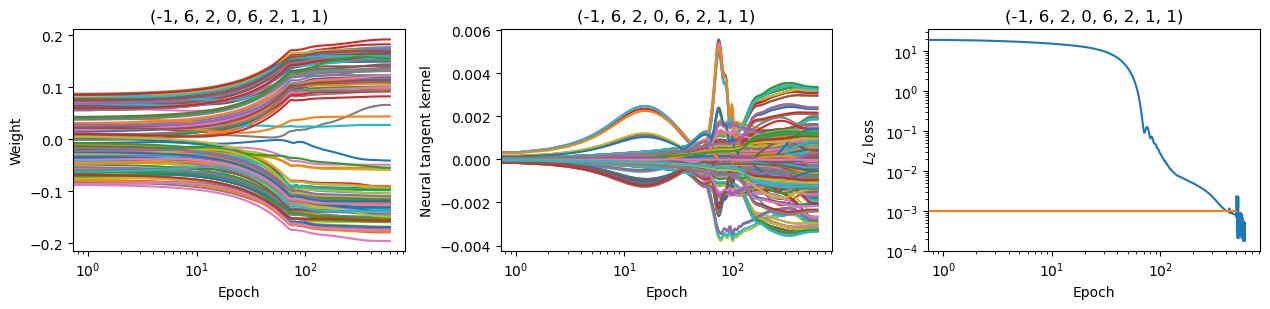

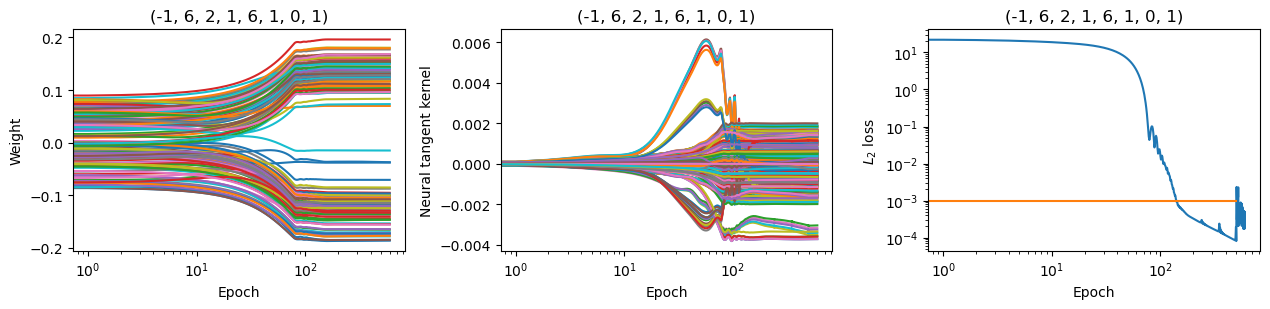

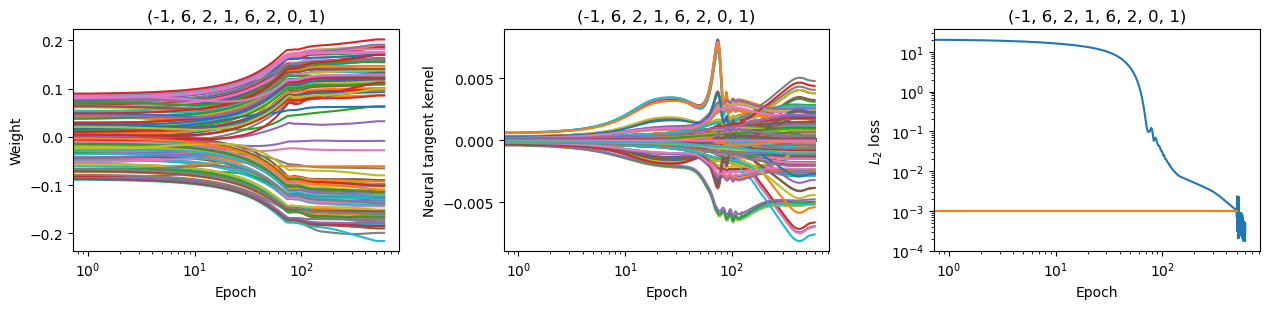

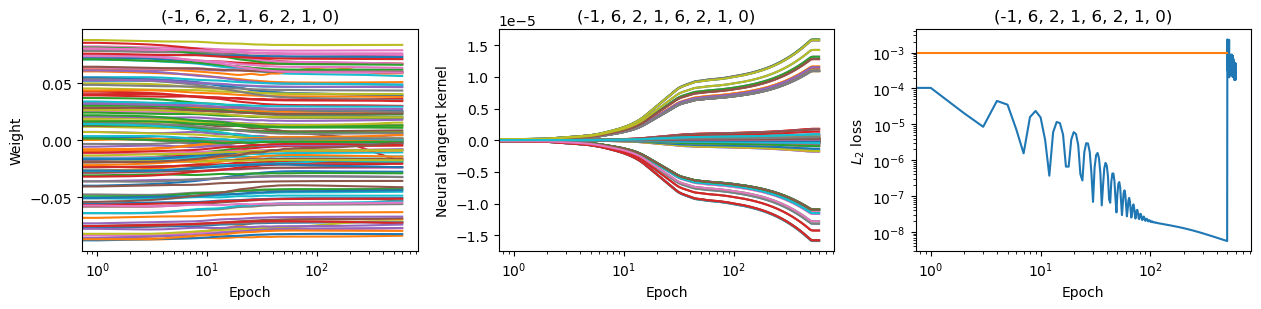

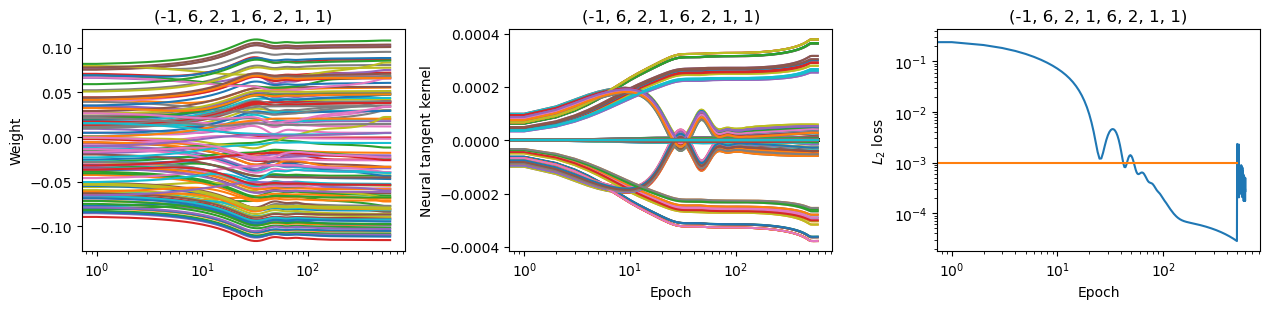

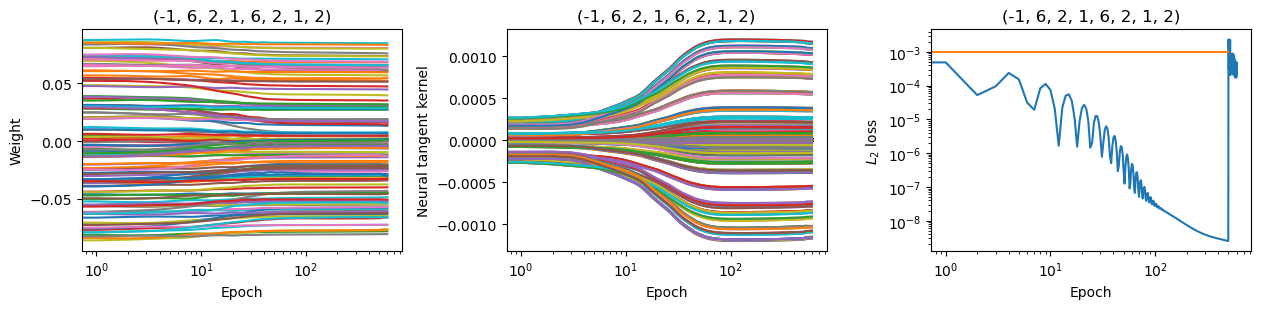

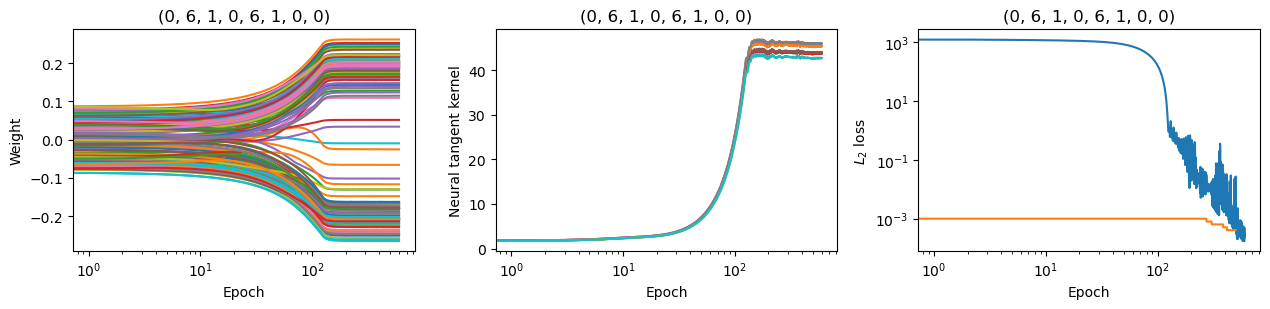

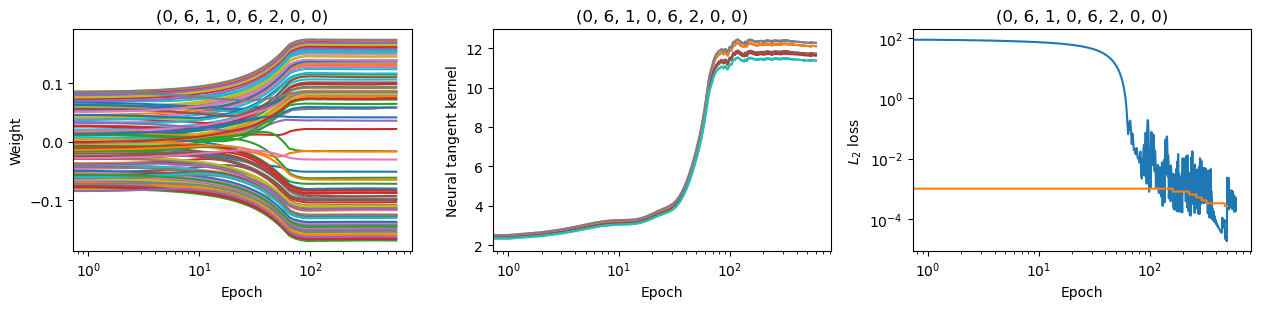

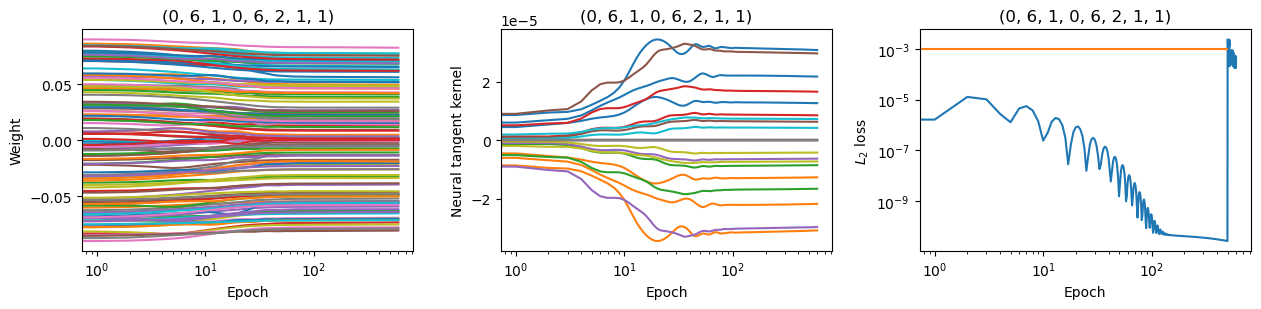

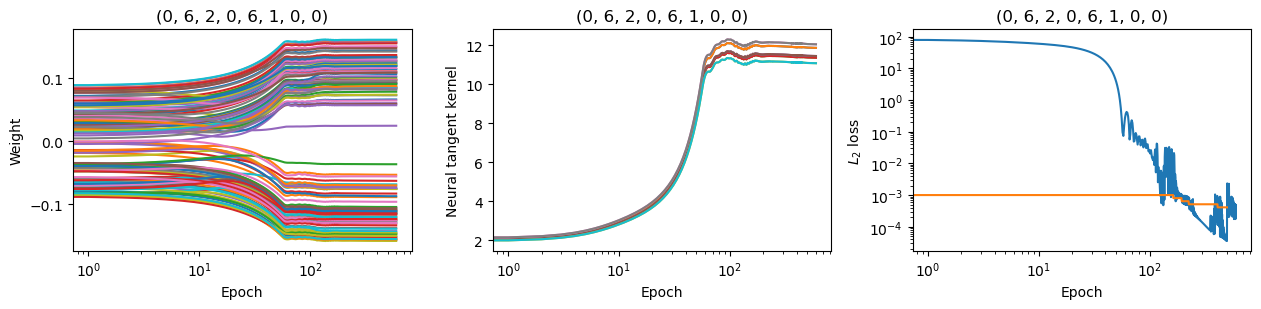

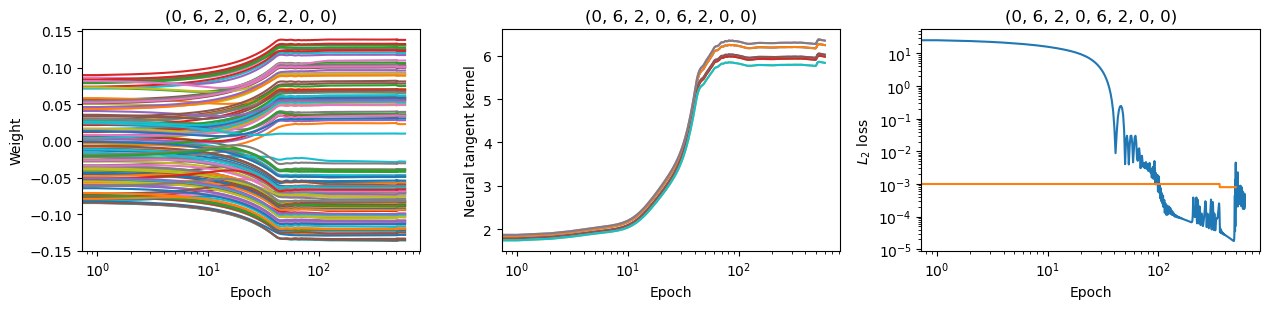

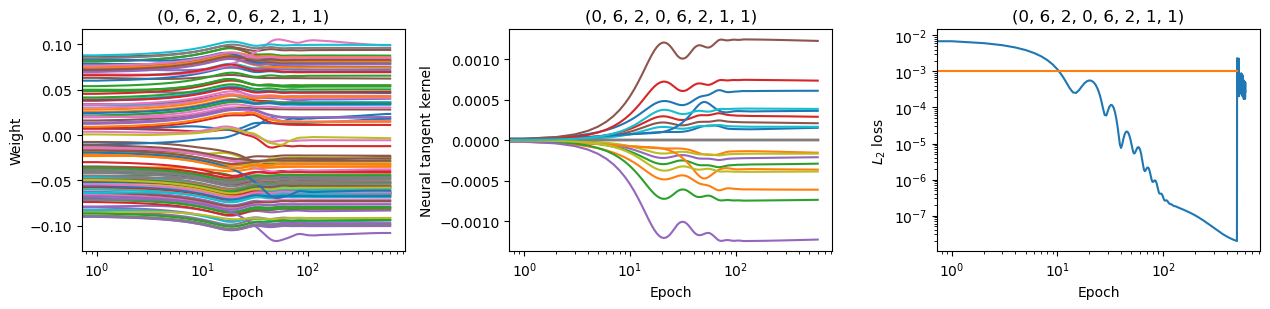

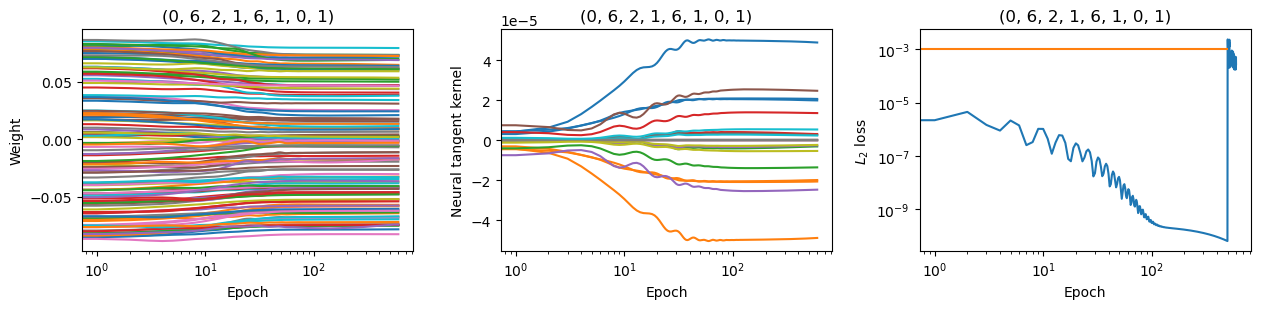

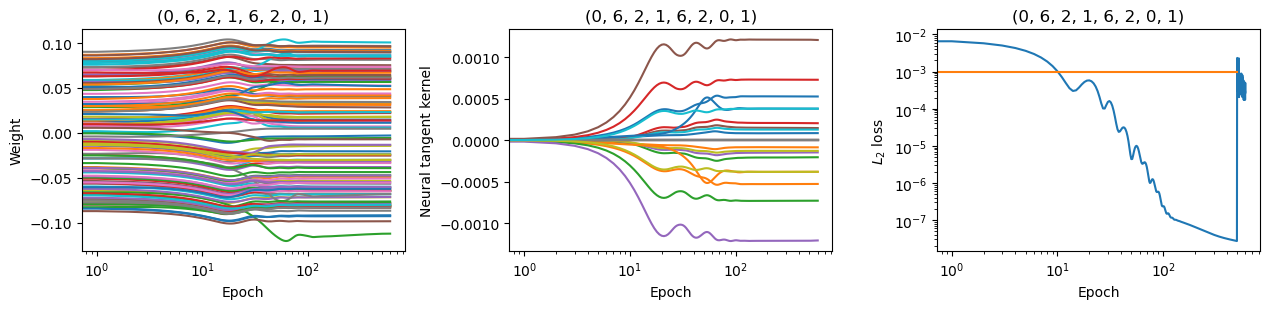

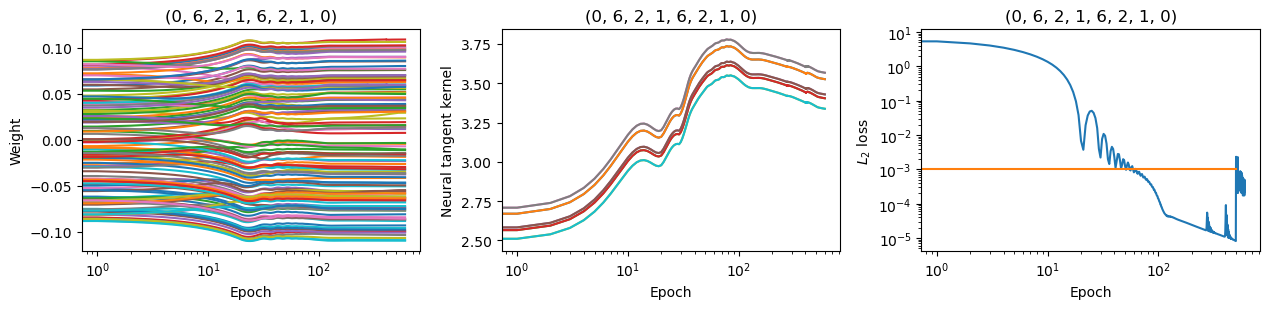

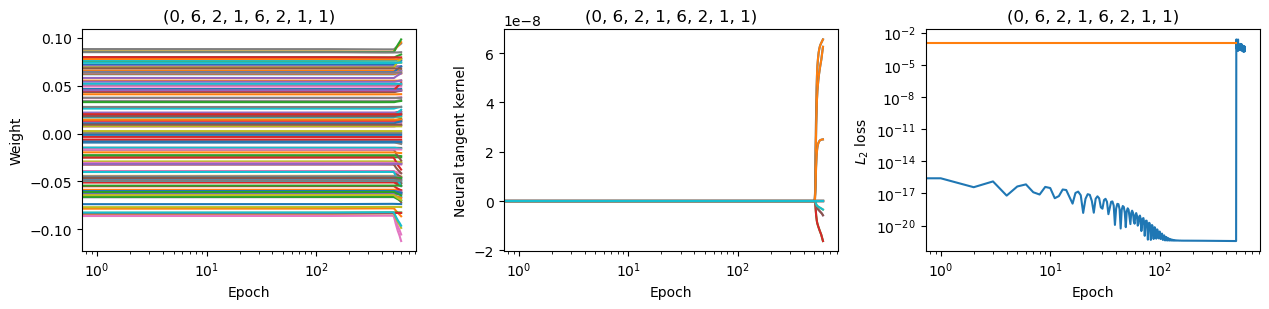

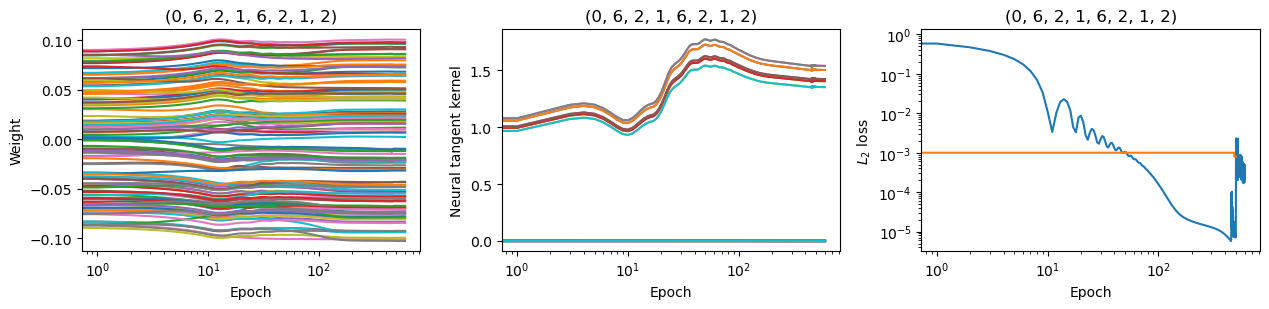

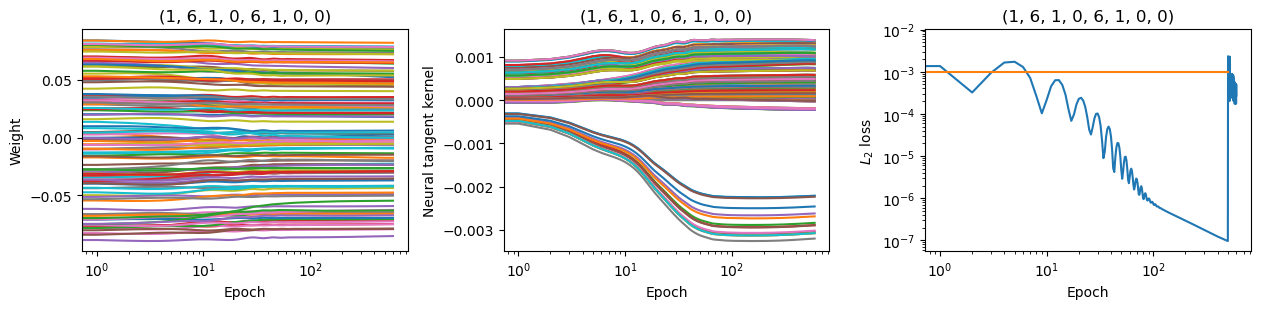

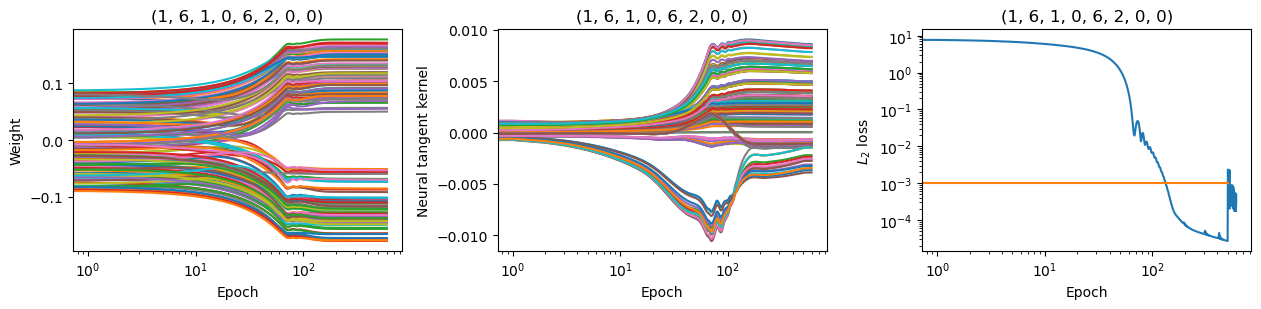

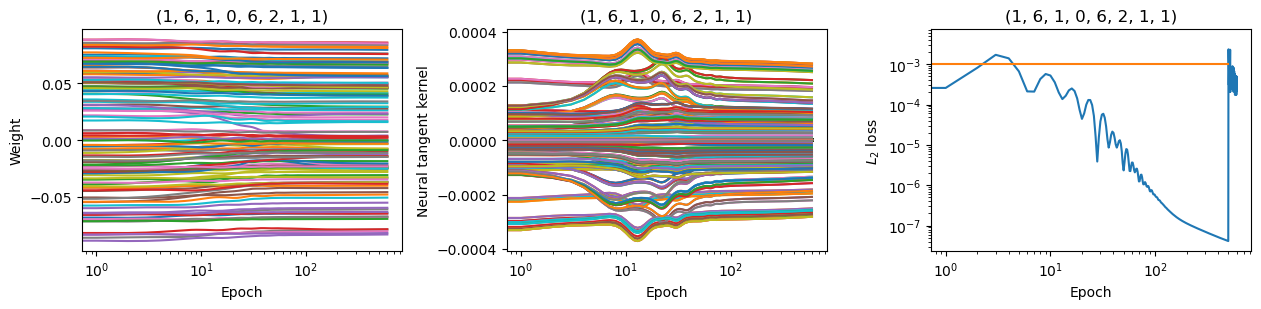

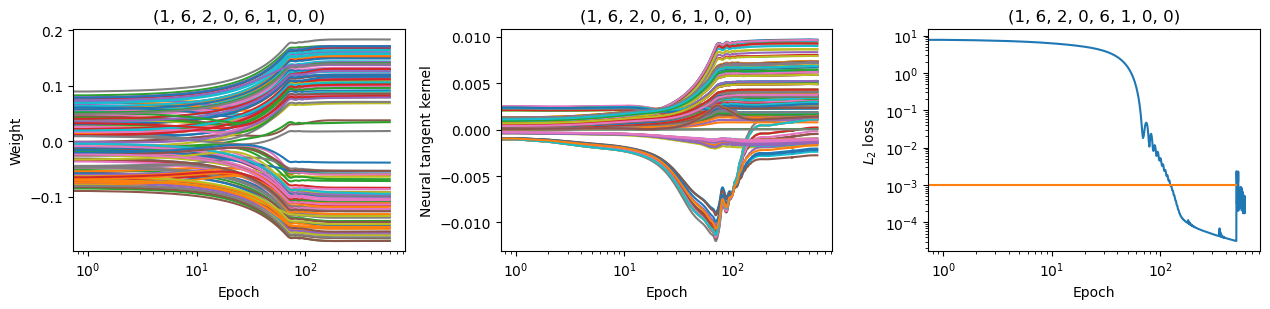

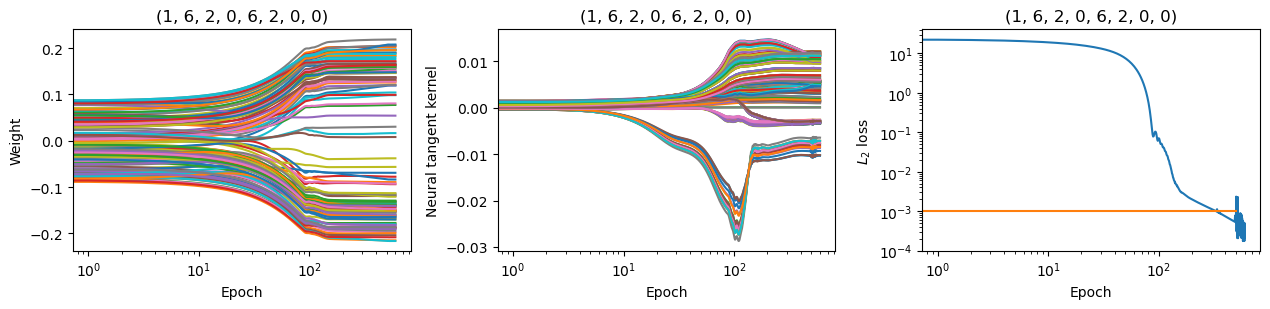

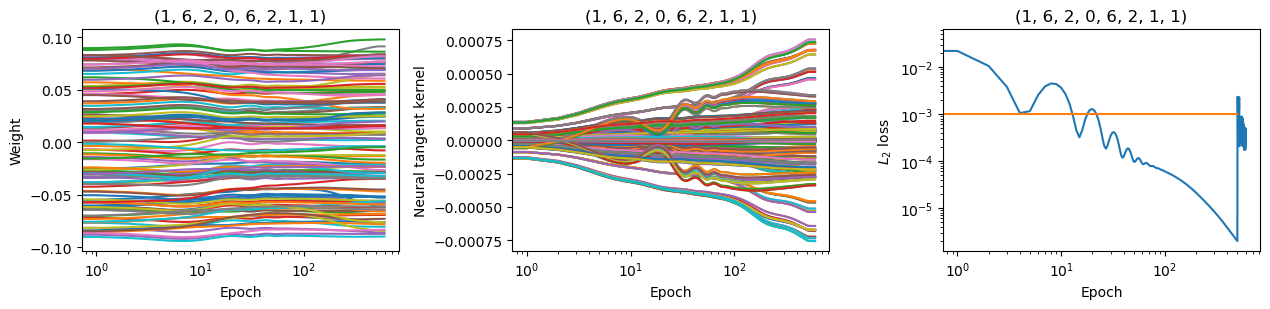

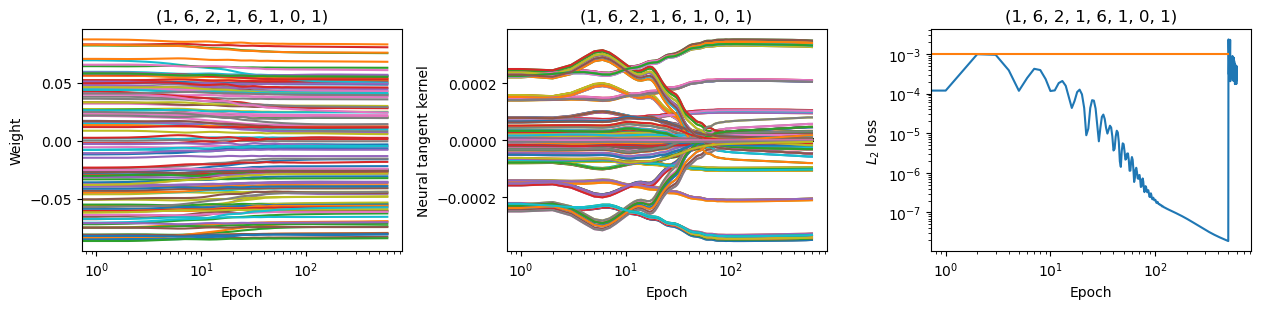

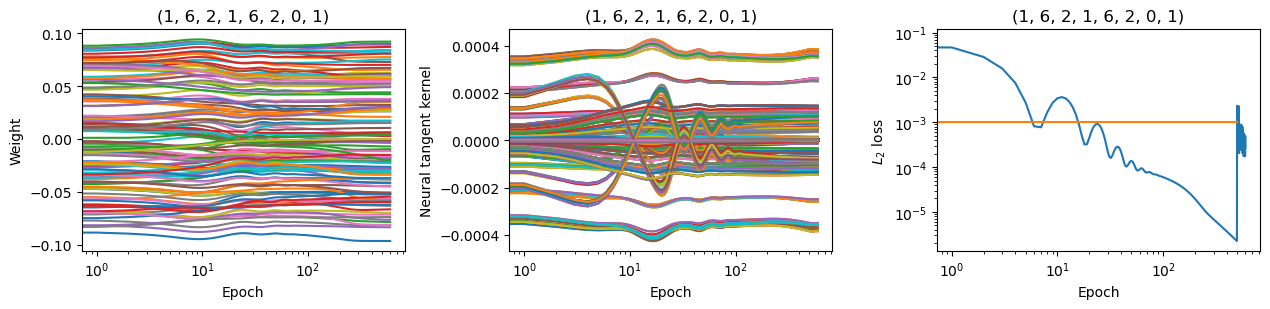

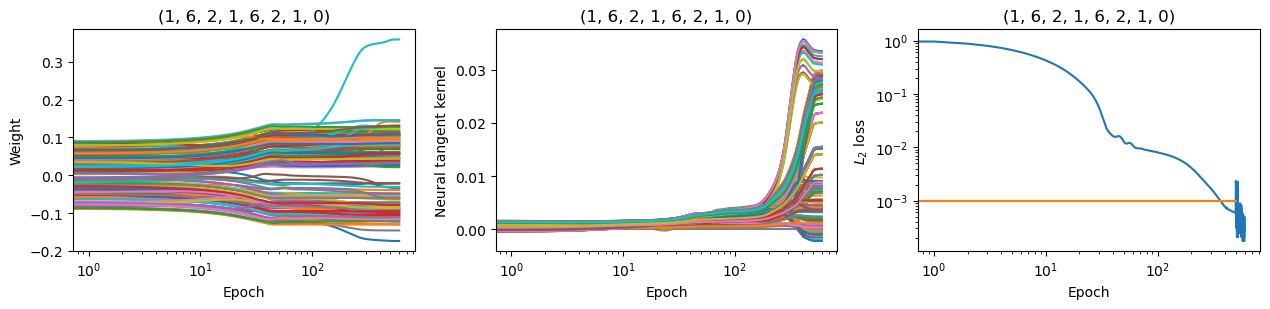

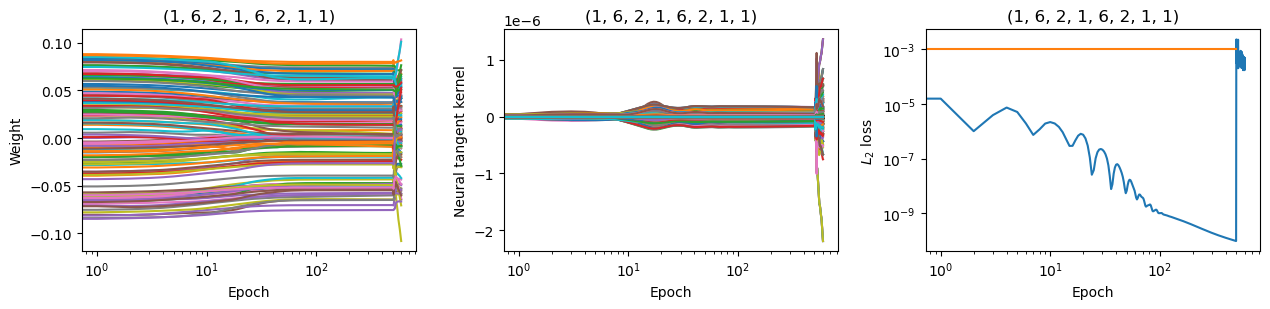

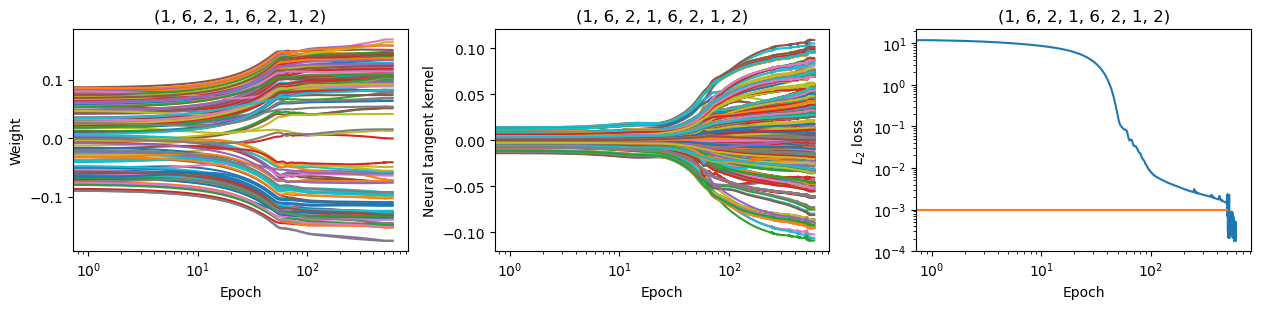

In [515]:
fs = plt.rcParams['figure.figsize']
for ik, k in enumerate(para):
    # if ik == 0:
    if True:
        kl = tuple(int(v) for v in k[1:-1].split(','))
        fig, axes = plt.subplots(ncols=3, figsize = (fs[0]*2, fs[1]/1.5))
        
        ax = axes[0]
        last_layer = torch.stack(para[k][5]).reshape(epoch+1, -1)
        for p in last_layer.T:
            y = p.detach().numpy()
            # y = np.abs(y-y[-1])
            # ax.plot(y/np.max(y))
            ax.plot(y)
        ax.set_title(k)
        ax.set_xscale('log')
        # ax.set_ylabel('$w$')
        # ax.set_ylabel(r'$\frac{w-w_{\mathrm{fin}}}{\mathrm{max}(w-w_{\mathrm{fin}})}$')
        ax.set_ylabel(r'Weight')
        ax.set_xlabel('Epoch')
    
        ax = axes[2]
        y = np.array(losses[k])
        ax.loglog(y)
        # ax.loglog(y/y[0])
        ax.loglog(learning_rates[k])
        ax.set_title(k)
        ax.set_ylabel('$L_2$ loss')
        # ax.set_ylabel('$L_2$ loss (normalized to 1 at epoch=0)')
        ax.set_xlabel('Epoch')
    
        # ax = axes[1]
        # kern = torch.stack(last_layer_kernel[kl])
        # for comp in range(kern.shape[1]):
        #     # y = torch.mean(kern[:, comp]-kern[-1, comp, :, :], dim = (1,2))
        #     # y_std = torch.std(kern[:, comp]-kern[-1, comp, :, :], dim = (1,2))
        #     # pl, = ax.plot(np.arange(len(y)), y)
        #     # ax.fill_between(np.arange(len(y)), y-y_std, y+y_std, alpha = 0.5, color = pl.get_color())
        #     for i in range(kern.shape[2]):
        #         for j in [0]: #range(kern[0].shape[1]):
        #             y = kern[:, comp, i, j]
        #             if j == 0:
        #                 pl, = ax.plot(y)
        #             else:
        #                 ax.plot(y, c = pl.get_color())
        # ax.set_ylabel('Neural tangent kernel')
        # ax.set_xlabel('Epoch')
        # ax.set_title(k)
                    
        # ax.set_xscale('log')
        fig.tight_layout()